# Statistical Analysis of Bay Area Bike Share Data

> From our initial Visual Exploratory Data Analysis on the Bay Area BIke Share dataset, we inferred that the vast majority of the trips are taken by cummuters, who are subscribers.
>
> Lets now see if we can show a statistical significance or coorelation between stations and trips.
>
>
>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

from scipy.stats import norm
from scipy import stats
import math

sns.set()

## Load Trip Data

In [2]:
print('Loading Trip Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_trip_data.csv'
    
    # glob all files
    file_list = glob(file_path_slug)
    
    trip_import = pd.DataFrame()
    
    counter = 1
    chunks = []
    
    # load data from each file
    for file in file_list:
        
        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
            
            # set chunk index column to 'Trip ID'
            chunk = chunk.set_index('Trip ID')
            
            # define Columns
            chunk.columns = ['Duration', 'Start Date', 'Start Station', 'Start Terminal', 'End Date', 
                             'End Station', 'End Terminal', 'Bike #', 'Subscriber Type', 'Zip Code']
            
            # append chunk to chunks list
            chunks.append(chunk)
        
        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1
    
    # concat chunks
    trip_import = pd.concat(chunks)
    
    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')


Loading Trip Data...
	Finished file! (1 of 4)
	Finished file! (2 of 4)
	Finished file! (3 of 4)
	Finished file! (4 of 4)
Data Loaded Successfully!


In [3]:
trip = trip_import.copy()
trip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983648 entries, 913465 to 198776
Data columns (total 10 columns):
Duration           983648 non-null int64
Start Date         983648 non-null object
Start Station      983648 non-null object
Start Terminal     983648 non-null int64
End Date           983648 non-null object
End Station        983648 non-null object
End Terminal       983648 non-null int64
Bike #             983648 non-null int64
Subscriber Type    983648 non-null object
Zip Code           976838 non-null object
dtypes: int64(4), object(6)
memory usage: 82.6+ MB


### Clean Trip info

In [4]:
# zipcodes are all over the place, only keep corrected 5 digit zipcodes, and replace all others with NaNs
def clean_zipcode(item):
    if len(item) != 5:

        # split on '-'
        try:
            result = item.split('-')[0]
        except:
            result = item

        # split on '.'
        try:
            result = item.split('.')[0]
        except:
            result = item
        
        # if len of item is less than 5, return 'NaN'
        if len(result) < 5:
            result = 'NaN'
        else:
            # if len result is greater than 5, take at most, first 5 digits
            result = result[:5]
    else:
        result = item
    
    # make sure result is all digits
    if result.isdigit():
        return result
    else:
        return 'NaN'

In [5]:
print('Trip Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in trip.columns:
    new_cols.append(col.replace(' ', '_').lower())
trip.columns = new_cols

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['duration', 'start_date', 'start_terminal', 'end_date', 'end_terminal', 'bike_#', 'subscriber_type', 'zip_code']
trip = trip[important_cols]

# create duration minutes column
print('\tcreating a duration_minutes column')
trip['duration_minutes'] = trip['duration'] / 60.0

# convert end and start dates to datetime objects
print('\tconverting end and start dates to datetime objects')
trip['start_date'] = pd.to_datetime(trip['start_date'], format="%m/%d/%Y %H:%M")
trip['end_date']   = pd.to_datetime(trip['end_date'],   format="%m/%d/%Y %H:%M")

# create a start and end hour trip column
print('\tcreating start_hour and end_hour columns')
trip['trip_date']  = trip['start_date'].dt.date
trip['start_hour'] = trip['start_date'].dt.hour
trip['end_hour']   = trip['end_date'].dt.hour



# convert and clean zipcodes
print('\tcleaning zipcodes')
trip['zip_code'] = trip['zip_code'].astype(str)
trip.zip_code = trip.zip_code.apply(clean_zipcode)
trip['zip_code'] = pd.to_numeric(trip['zip_code'], errors='coerce')


print('Trip Data Cleanup complete')
trip_clean = trip.copy()

Trip Data Cleanup Started...
	cleaning column names
	subsetting to useful columns
	creating a duration_minutes column
	converting end and start dates to datetime objects
	creating start_hour and end_hour columns
	cleaning zipcodes
Trip Data Cleanup complete


### Prune Trip Data to exlude outliers previously discovered, and only San Francisco Trips

In [6]:
# our data set show duration in seconds, here are some handy conversions
second = 1
minute = second * 60
hour = minute * 60
day = hour * 24

# station ID numbers that are in San Francisco
sf_stations = [ 39,41,42,45,46,47,48,49,50,51,54,55,56,57,58,59,60,61,62,63,
                64,65,66,67,68,69,70,71,72,73,74,75,76,77,82,90,91]

In [7]:
# prune data to exclude trips longer than 60 minutes
print('pruning data to trips no more than 60 minutes long...')
trips_clean = trip_clean[trip_clean['duration'] <= 60 * minute].copy()
print('\tpruned data set \'trips_clean\' consists of %i entries' % len(trips_clean.index))

# Cleanup
trips_clean.sort_index(inplace=True)


pruning data to trips no more than 60 minutes long...
	pruned data set 'trips_clean' consists of 955557 entries


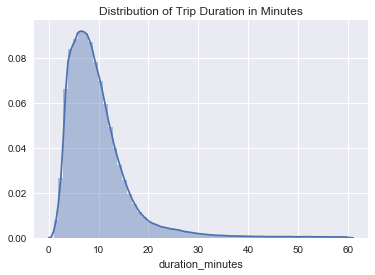

In [8]:
# plot histogram of trip duration
# trips_sf['duration_minutes'].plot(kind='hist', color='r', alpha=0.25, bins=200, figsize=(20,5))
sns.distplot(trips_clean['duration_minutes'], bins=60)
plt.title('Distribution of Trip Duration in Minutes')
plt.xlabel='Trip Duration (Minutes)'
plt.ylabel='Number of Trips'
plt.legend(loc='best')
plt.show()

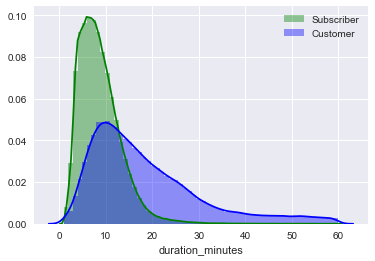

In [9]:
sns.set()
sns.distplot(trips_clean[trips_clean['subscriber_type'] == 'Subscriber'].duration_minutes, color='g', label='Subscriber', bins=60)
sns.distplot(trips_clean[trips_clean['subscriber_type'] == 'Customer'].duration_minutes, color='b', label='Customer', bins=60)
plt.legend()
plt.show()

#### Is this a normal distribution?

In [10]:
_all = stats.normaltest(trips_clean.duration_minutes.sort_values())
_subscribers = stats.normaltest(trips_clean[trips_clean['subscriber_type'] == 'Subscriber'].duration_minutes.sort_values())
_customers = stats.normaltest(trips_clean[trips_clean['subscriber_type'] == 'Customer'].duration_minutes.sort_values())

print(_all)
print(_subscribers)
print(_customers)

NormaltestResult(statistic=585662.35366654606, pvalue=0.0)
NormaltestResult(statistic=378124.95124261698, pvalue=0.0)
NormaltestResult(statistic=22235.995822342164, pvalue=0.0)


In [11]:
# sample size
_all = len(trips_clean.index)
_subscribers = len(trips_clean[trips_clean['subscriber_type'] == 'Subscriber'].index)
_customers = len(trips_clean[trips_clean['subscriber_type'] == 'Customer'].index)

print('Number of trips taken by \'all users\'\t', _all)
print('Number of trips taken by \'subscribers\'\t', _subscribers)
print('Number of trips taken by \'customers\'\t', _customers)

Number of trips taken by 'all users'	 955557
Number of trips taken by 'subscribers'	 844570
Number of trips taken by 'customers'	 110987


## Hypothesis 1

> $H$o : Mean 'Subscriber' trip duration < Mean 'Customer' trip duration
>
> $H$a : Mean 'Subscriber' trip duration >= Mean 'Customer' trip duration

In [19]:
sub_data = trips_clean[trips_clean.subscriber_type == 'Subscriber']['duration_minutes']
cust_data = trips_clean[trips_clean.subscriber_type == 'Customer']['duration_minutes']

In [21]:
# difference of means
sub_mean = sub_data.mean()
print('subscriber mean:\t', sub_mean)

cust_mean = cust_data.mean()
print('customer mean:\t\t', cust_mean)

diff = sub_mean - cust_mean
print('Difference of means:\t', diff)

subscriber mean:	 8.79435941761
customer mean:		 18.5433866128
Difference of means:	 -9.74902719523


In [23]:
# calculate margin of error
sub_var = sub_data.var()
cust_var = cust_data.var()
var = sub_var + cust_var/2

sub_count = len(sub_data)
cust_count = len(cust_data)

std_error = math.sqrt(sub_var/sub_count + cust_var/cust_count)
print('Standard Error:\t\t', std_error)

# margin of error
margin = 1.96*std_error
print('Margin of Error:\t', margin)

Standard Error:		 0.0362181874173167
Margin of Error:	 0.07098764733794073


In [25]:
# calcuate t statistic and pvalue
t, p = stats.ttest_ind(sub_data, cust_data)
print('t statistic:\t', t)
print('p value:\t', p)

t statistic:	 -508.70395135
p value:	 0.0


## Load Weather Data

In [ ]:
print('Loading Weather Data...')

try:
    file_path_slug = '../../datasets/bayareabikeshare/*_weather_data.csv'
    
    # glob all files
    file_list = glob(file_path_slug)
    
    weather_import = pd.DataFrame()
    
    counter = 1
    chunks = []
    
    # load data from each file
    for file in file_list:
        
        # import file in chunks
        for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
                        
            # define Columns
            chunk.columns = ['Date', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF', 'Max_Dew_Point_F', 
                             'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 
                             'Max_Sea_Level_Pressure_In', 'Mean_Sea_Level_Pressure_In', 'Min_Sea_Level_Pressure_In', 
                             'Max_Visibility_Miles', 'Mean_Visibility_Miles', 'Min_Visibility_Miles', 
                             'Max_Wind_Speed_MPH', 'Mean_Wind_Speed_MPH', 'Max_Gust_Speed_MPH', 'Precipitation_In', 
                             'Cloud_Cover', 'Events', 'Wind_Dir_Degrees', 'zip']

            # append chunk to chunks list
            chunks.append(chunk)
        
        print('\tFinished file! (%d of %d)' % (counter, len(file_list)))
        counter += 1
    
    # concat chunks
    weather_import = pd.concat(chunks)
    
    print('Data Loaded Successfully!')

except:
    print('oops... something went wrong importing the data :(')



In [ ]:
weather_data = weather_import.copy()
weather_data.info()

### Clean Weather info

In [ ]:
print('Weather Data Cleanup Started...')

# cleanup column names
print('\tcleaning column names')
new_cols = []
for col in weather_data.columns:
    new_cols.append(col.replace(' ', '_').lower())
weather_data.columns = new_cols
weather = weather_data.copy()

# convert end and start dates to datetime objects
print('\tconverting dates to datetime objects')
weather['date'] = pd.to_datetime(weather['date'], format="%m/%d/%Y")

# extract columns we want to keep
print('\tsubsetting to useful columns')
important_cols = ['date', 'max_temperature_f', 'mean_temperature_f', 'min_temperaturef',
                  'max_dew_point_f', 'meandew_point_f', 'min_dewpoint_f',
                  'max_wind_speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
                  'precipitation_in', 'cloud_cover', 'events', 'zip']
weather = weather[important_cols]

# correct min_temperaturef column name to min_temperature_f
# weather['min_temperaturef'].rename('min_temperature_f')
weather.rename(columns={'min_temperaturef': 'min_temperature_f'}, inplace=True)

# cleanup and set date as index
weather.set_index('date', inplace=True)
weather.sort_index(inplace=True)

# cleanup precipitation data to be all float values
weather['precipitation_in'] = pd.to_numeric(weather['precipitation_in'], errors='coerce')

print('Weather Data Cleanup complete')

### Prune Weather Data to include only San Francisco Zip Code Data

In [ ]:
# prune weather data to only San Francisco data
print('pruning weather data to only San Francisco data')
weather_sf = weather[weather['zip'] == 94107].copy()


# Cleanup
weather_sf.sort_index(inplace=True)
print('\tpruned data set \'weather_sf\' consists of %i entries' % len(weather_sf.index))


# note the one day with a min temperature of zero
# that has not happened in San Francisco since 1932, so this can be ignored
weather_sf = weather_sf[weather_sf['min_temperature_f'] > 5.0]

In [ ]:
weather_sf.info()

In [ ]:
# plot temperatures for San Francisco
weather_sf[['max_temperature_f', 'min_temperature_f', 'mean_temperature_f']].plot(figsize=(20,5))
plt.title('Temperature by Day in San Francisco')
plt.xlabel='Date'
plt.ylabel='Temperature (F)'
plt.legend(loc='best')
plt.show()

In [ ]:
# plot rain accumulation by day
weather_sf[weather_sf['precipitation_in'] > 0.0]['precipitation_in'].plot(kind='bar', figsize=(20,5))
plt.title('Precipitation by Day in San Francisco')
plt.xlabel='Date'
plt.ylabel='Preicpitation (in)'
plt.legend(loc='best')
plt.show()

In [ ]:

num_rainy_days = len(weather_sf[weather_sf['precipitation_in'] > 0.0].index)
num_days = len(weather_sf.index)
ration_rainy_days = num_rainy_days / num_days * 100.0

print('There are %s rainy days out of %s total reported days (%s)' % (num_rainy_days, num_days, ration_rainy_days))

## Data Investigation

In [ ]:
# Graph monthly ride totals by subscriber type
ax = trips_sf[trips_sf['subscriber_type'] == 'Subscriber'].groupby([trips_sf['start_date'].dt.year, trips_sf['start_date'].dt.month])['duration_minutes'].count().plot(kind='bar', color='b', figsize=(10,5))
trips_sf[trips_sf['subscriber_type'] == 'Customer'].groupby([trips_sf['start_date'].dt.year, trips_sf['start_date'].dt.month])['duration_minutes'].count().plot(kind='bar', color='g', ax=ax)

plt.title('San Francisco Trips by Month')
plt.xlabel='Start Hour'
plt.legend(loc='best')
plt.show()

In [ ]:
# create a joined dataframe for statistical analysis ease
data_check = pd.DataFrame()
data_check['trips'] = trips_sf.groupby(['trip_date'])['bike_#'].count()
data_check['mean_temp'] = weather_sf['mean_temperature_f']
data_check['max_temp'] = weather_sf['max_temperature_f']
data_check['min_temp'] = weather_sf['min_temperature_f']
data_check['precipitation_in'] = weather_sf['precipitation_in']
data_check['cloud_cover'] = weather_sf['cloud_cover']
data_check = data_check[data_check['min_temp'] > 20.0]
data_check.info()

In [ ]:
# create rainy days only dataframe
rainy_days = data_check[np.isfinite(data_check['precipitation_in'])]
# prune only days where recorded rain is greater than 0.0
rainy_days = rainy_days[rainy_days['precipitation_in'] > 0.0]
rainy_days.info()

In [ ]:
data_check.head()

## Statistical Analysis

In [ ]:
sns.jointplot('trips', 'cloud_cover', data=data_check, kind='reg')
plt.show()

In [ ]:
sns.jointplot('trips', 'precipitation_in', data=data_check, kind='reg')
plt.show()

In [ ]:
sns.jointplot('trips', 'max_temp', data=data_check, kind='reg')
plt.show()

In [ ]:
# plot rides by cloud cover
sns.boxplot(x='cloud_cover', y='trips', data=data_check)
plt.show()


In [ ]:
sns.jointplot('cloud_cover', 'trips', data=data_check, kind='reg')
plt.show()